# Regresión Logística Multinomial (o Softmax Regression)

<img src="img/MulLog_neuron_1.png" width="800">

<img src="img/MulLog_softmax_2.png" width="800">

<img src="img/MulLog_loss-input-classification_3.png" width="800">

In [1]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import torch
from torch.utils.data import TensorDataset, DataLoader
from torch import nn, optim
import torch.nn.functional as F

import numpy as np

import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
##########################
### CONFIGURACION
##########################

RANDOM_SEED = 1
BATCH_SIZE = 64
NUM_EPOCHS = 100
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
lr = 0.01

torch.manual_seed(RANDOM_SEED);

In [3]:
digits = datasets.load_digits()
X = digits['data']
y = digits['target']

# X = (X - X.mean(axis=0))/X.std(axis=0)
# sc = StandardScaler()
# X = sc.fit_transform(X)

In [4]:
print(X.shape)
print(y.shape)

(1797, 64)
(1797,)


In [5]:
X_train,X_valid,y_train,y_valid = train_test_split(X, y, test_size=0.3, random_state=RANDOM_SEED)

In [6]:
X_train, y_train, X_valid, y_valid = map( lambda x: torch.tensor(x, dtype=torch.float32),
                                         (X_train, y_train, X_valid, y_valid) )

In [7]:
train_ds = TensorDataset(X_train, y_train)
valid_ds = TensorDataset(X_valid, y_valid)

train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size = 2*BATCH_SIZE)

In [8]:
print(X_train.shape)
print(y_train.shape)

torch.Size([1257, 64])
torch.Size([1257])


### 1. Forma explícita (con `nn`)

In [9]:
# class Logistic(nn.Module):
#     def __init__(self, num_features, num_outputs):
#         super().__init__()
#         self.weights = nn.Parameter(torch.zeros(num_features,num_outputs))
#         self.bias = nn.Parameter(torch.zeros(num_outputs))
        
#     def forward(self,x):
#         return x @ self.weights + self.bias

### 2. Forma semi-explicita

In [10]:
# class Logistic(nn.Module):
#     def __init__(self, num_features, num_outputs):
#         super().__init__()
#         self.lin = nn.Linear(num_features,num_outputs)
#         self.lin.weight.detach().zero_()
#         self.lin.bias.detach().zero_()
        
#     def forward(self,x):
#         return self.lin(x)

In [11]:
# model = Logistic(X.shape[1],10)

### 3. Secuencial

In [12]:
model = nn.Sequential(
    nn.Linear(X.shape[1],10),
)

In [13]:
# Esto es para inicializar los pesos a ceros una vez definido el modelo
# (por defecto con nn se inicializan con Xavier, Hu o similar)
# def weights_init(m):
#     if isinstance(m, nn.Linear):
#         nn.init.zeros_(m.weight)
#         nn.init.zeros_(m.bias)
#         print(m.weight)

# model.apply(weights_init)

In [14]:
loss_func = F.cross_entropy

In [15]:
model = model.to(DEVICE)

opt = optim.SGD(model.parameters(),lr = lr)

Probando un minibatch

In [16]:
xp, yp = next(iter(train_dl))
print(xp.shape,yp.shape)

torch.Size([64, 64]) torch.Size([64])


In [17]:
loss_func(model(xp.to(DEVICE)),yp.long().to(DEVICE))

tensor(6.8702, device='cuda:0', grad_fn=<NllLossBackward>)

In [18]:
y_pred = torch.argmax(model(xp.to(DEVICE)), 1)
(y_pred == yp.to(DEVICE)).float().mean().item()

0.0625

In [19]:
def loss_acc_batch(x,y, acc = None):
    yp = model(x.to(DEVICE))
    yt = y.to(DEVICE).long() # .long() porque espera un entero tipo long
    loss = loss_func(yp, yt)
    out = [loss, len(x)]
    
    if acc is not None:
        y_pred = torch.argmax(model(x.to(DEVICE)), 1) 
        accuracy = (y_pred == yt).float().mean().item()
        out.append(accuracy)
    return out

In [20]:
def train():
    
    train_losses = []
    valid_losses = []
    for epoch in range(NUM_EPOCHS):
        model.train()
        losses = 0
        nums = 0
        for x, y in train_dl:
            loss, l = loss_acc_batch(x,y)
            loss.backward()
            opt.step()
            opt.zero_grad()
            
            losses += loss.item() * l
            nums += l
        train_loss = losses / nums
        train_losses.append(train_loss)
        
        model.eval()
        with torch.no_grad():
            losses, nums, accs = zip(*[loss_acc_batch(xb, yb, acc=True) for xb, yb in valid_dl])
        losses = [l.item() for l in losses]
        valid_loss = np.sum(np.multiply(losses,nums)) / np.sum(nums)
        valid_losses.append(valid_loss)
        
        valid_acc = np.sum(np.multiply(accs,nums)) / np.sum(nums)
        
        if epoch % 10 == 0:
            print(f"epoch: {epoch},    train_loss: {train_loss:.4f} \
            valid_loss: {valid_loss:.4f}, valid_acc: {valid_acc:.4f}")
    
    plt.plot(range(NUM_EPOCHS), train_losses, 'r', label='train')
    plt.plot(range(NUM_EPOCHS), valid_losses, 'b', label = 'valid')
    plt.legend()

epoch: 0,    train_loss: 2.1363             valid_loss: 0.8308, valid_acc: 0.7463
epoch: 10,    train_loss: 0.1370             valid_loss: 0.1557, valid_acc: 0.9519
epoch: 20,    train_loss: 0.0970             valid_loss: 0.1385, valid_acc: 0.9611
epoch: 30,    train_loss: 0.0747             valid_loss: 0.1199, valid_acc: 0.9648
epoch: 40,    train_loss: 0.0632             valid_loss: 0.1144, valid_acc: 0.9630
epoch: 50,    train_loss: 0.0541             valid_loss: 0.1067, valid_acc: 0.9667
epoch: 60,    train_loss: 0.0480             valid_loss: 0.1066, valid_acc: 0.9648
epoch: 70,    train_loss: 0.0452             valid_loss: 0.1005, valid_acc: 0.9667
epoch: 80,    train_loss: 0.0395             valid_loss: 0.1029, valid_acc: 0.9648
epoch: 90,    train_loss: 0.0370             valid_loss: 0.0969, valid_acc: 0.9722


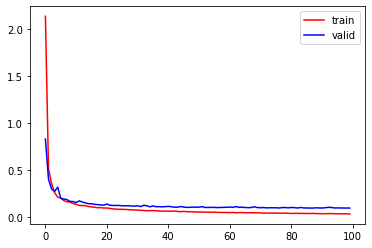

In [21]:
train()